<a href="https://colab.research.google.com/github/MehaRima/2sxc-content-app/blob/master/Copy_of_practice_reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REINFORCE in TensorFlow

Just like we did before for Q-learning, this time we'll design a TensorFlow network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
!pip install tensorflow==1.2

# For the latest nightly build:
!pip install tf-nightly
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive
!apt-get -qq install python-cartopy python3-cartopy
import cartopy
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

Name: tensorflow
Version: 1.2.0
Summary: TensorFlow helps the tensors flow
Home-page: http://tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: werkzeug, bleach, html5lib, markdown, wheel, protobuf, backports.weakref, six, numpy
Required-by: fancyimpute
     |████████████████████████████████| 320.4MB 19kB/s 
  Found existing installation: tensorflow 1.2.0
    Uninstalling tensorflow-1.2.0:
      Successfully uninstalled tensorflow-1.2.0
  Using cached https://files.pythonhosted.org/packages/5e/55/7995cc1e9e60fa37ea90e6777d832e75026fde5c6109215d892aaff2e9b7/tensorflow-1.2.0-cp36-cp36m-manylinux1_x86_64.whl
Processing /root/.cache/pip/wheels/b6/52/17/f0af18e3e0ec6fa60b361ffed15b4c3468f6f3bcdb87fbe079/Markdown-2.2.0-cp36-none-any.whl
ERROR: tensorboard 2.3.0 has requirement markdown>=2.6.8, but you'll have markdown 2.2.0 which is incompatible.
ERROR: tb-nightly 2.4.0a20200901 has requiremen

In [ ]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week5_policy_based/submit.py

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

TensorFlow 1.x selected.
Starting virtual X frame buffer: Xvfb.


In [ ]:
!pip install gym==0.14.0 
!pip install pyglet==1.3.2

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: we have received reports that the following cell may crash with `NameError: name 'base' is not defined`. The [suggested workaround](https://www.coursera.org/learn/practical-rl/discussions/all/threads/N2Pw652iEemRYQ6W2GuqHg/replies/te3HpQwOQ62tx6UMDoOt2Q/comments/o08gTqelT9KPIE6npX_S3A) is to install `gym==0.14.0` and `pyglet==1.3.2`.

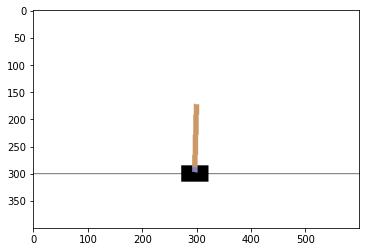

In [ ]:


import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env,'env'):
    env=env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [ ]:
import tensorflow as tf

# create input variables. We only need <s,a,R> for REINFORCE
states = tf.placeholder('float32', (None,) + state_dim, name="states")
actions = tf.placeholder('int32', name="action_ids")
cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

In [ ]:

from tensorflow import keras
from tensorflow.keras import layers as L

model = keras.models.Sequential()
model.add(L.InputLayer(input_shape=state_dim))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(n_actions, activation='linear'))

logits = model(states)

policy = tf.nn.softmax(logits)
log_policy = tf.nn.log_softmax(logits)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
import tensorflow as tf

sess = tf.InteractiveSession()

In [ ]:
# Initialize model parameters
sess.run(tf.global_variables_initializer())

In [ ]:
# utility function to pick action in one given state
def get_action_proba(s): 
    return policy.eval({states: [s]})[0]

### Play the game

We can now use our newly built agent to play the game.

In [ ]:

# select log-probabilities for chosen actions, log pi(a_i|s_i)
indices = tf.stack([tf.range(tf.shape(log_policy)[0]), actions], axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)

In [ ]:
# REINFORCE objective function
# hint: you need to use log_policy_for_actions to get log probabilities for actions taken

J =  tf.reduce_mean(log_policy_for_actions * cumulative_rewards)

In [ ]:
entropy = -tf.reduce_sum(policy * log_policy, 1, name='entropy')

In [ ]:
# all network weights
all_weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

# weight updates. maximizing J is same as minimizing -J. Adding negative entropy.
loss = -J - 0.1*entropy

update = tf.train.AdamOptimizer().minimize(loss, var_list=all_weights)

### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [ ]:
def get_cumulative_rewards(rewards,    # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """

    rewards = rewards[::-1]
    
    cumulative_rewards = [float(rewards[0])]
    for i in rewards[1:]:
        cumulative_rewards.append(i + gamma * cumulative_rewards[-1])
        
    return cumulative_rewards[::-1]

In [ ]:
get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9)


[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0]

In [ ]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse Tensorflow's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

As a reminder, for a discrete probability distribution (like the one our policy outputs), entropy is defined as:

$$ \operatorname{entropy}(p) = -\sum_{i = 1}^n p_i \cdot \log p_i $$

In [ ]:
# # Maximizing X is the same as minimizing -X, hence the sign.
loss = -(J + 0.1 * entropy)

update = tf.train.AdamOptimizer().minimize(loss)

In [ ]:
def train_step(_states, _actions, _rewards):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    update.run({states: _states, actions: _actions,
                cumulative_rewards: _cumulative_rewards})

In [ ]:
def train_on_session(states, actions, rewards, t_max=1000):
    """given full session, trains agent with policy gradient"""
    cumulative_rewards = get_cumulative_rewards(rewards)
    update.run({
        ph_states: states,
        ph_actions: actions,
        ph_cumulative_rewards: cumulative_rewards,
    })
    return sum(rewards)

In [ ]:
# Initialize optimizer parameters
sess.run(tf.global_variables_initializer())

### The actual training

In [ ]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""

    # arrays to record session
    states, actions, rewards = [], [], []

    s = env.reset()

    for t in range(t_max):

        # action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s)

        a = np.random.choice([0, 1], p=action_probas)

        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    train_step(states, actions, rewards)

    # technical: return session rewards to print them later
    return sum(rewards)

In [ ]:
s = tf.InteractiveSession()
s.run(tf.global_variables_initializer())

for i in range(100):

    rewards = [generate_session() for _ in range(100)]  # generate new sessions

    print("mean reward: %.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 300:
        print("You Win!") # but you can train even further
        break

/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


mean reward: 52.750
mean reward: 462.440
You Win!


### Results & video

In [ ]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

In [ ]:

from submit import submit_cartpole
submit_cartpole(generate_session,'sahelirima23@gmail.com', 'LfPdKzCRUctdq8B6')

Submitted to Coursera platform. See results on assignment page!


That's all, thank you for your attention!

Not having enough? There's an actor-critic waiting for you in the honor section. But make sure you've seen the videos first.